In [119]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



In [ ]:
churn_data = pd.read_csv("data\\churn_data.csv")

# Exploratory Data Analysis

In [34]:
#Check basic info
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

## Checking Cardinality

In [ ]:
churn_data['State'].value_counts()

In [ ]:
churn_data['International plan'].value_counts()
#We have more non-international plan

In [14]:
churn_data['Voice mail plan'].value_counts()
#We have more non-voice mail plan

Voice mail plan
No     2411
Yes     922
Name: count, dtype: int64

In [ ]:
def hist_plot(data,xlab,title):
    plt.hist(data,color='skyblue',edgecolor='black')
    plt.xlabel(xlab)
    plt.title(title)


In [ ]:
hist_plot(churn_data['Total day minutes'],'Total Day Minutes','Frequency')
#Seems like a normally distributed data

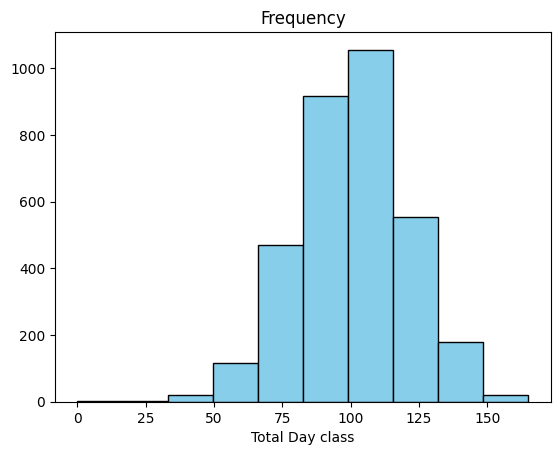

In [21]:
hist_plot(churn_data['Total day calls'],'Total Day calls','Frequency')
#Negatively Skewed Data.

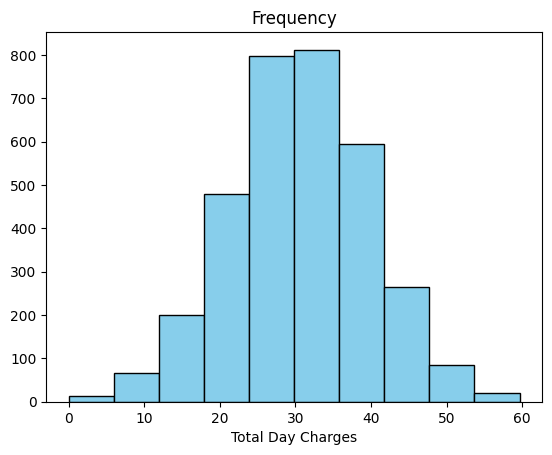

In [23]:
hist_plot(churn_data['Total day charge'],'Total Day Charges','Frequency')
#Normaly distributed

Text(0, 0.5, 'Total Day Charge')

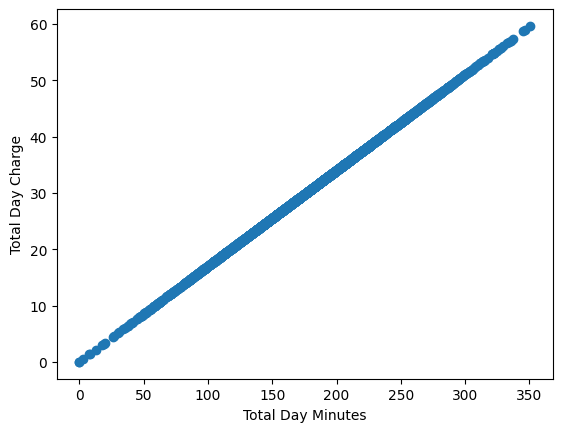

In [26]:
plt.scatter(churn_data['Total day minutes'],churn_data['Total day charge'])
plt.xlabel("Total Day Minutes")
plt.ylabel("Total Day Charge")

Perfect linear relationship. This is expected as we are being charge more as we take on longer calls. Let's check if there is also a linear relationship between total day calls and total day minutes.

Text(0, 0.5, 'Total Day Minutes')

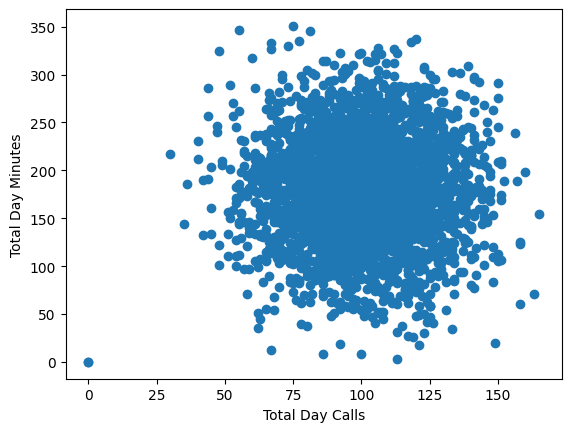

In [28]:
plt.scatter(churn_data['Total day calls'], churn_data['Total day minutes'])
plt.xlabel('Total Day Calls')
plt.ylabel('Total Day Minutes')

No linear relationship for these 2 numerical variable. This kind of make sense, because the number of calls you make per day doesn't really mean that you will have higher minutes of call. One can make 3 calls in day where in each call lasts for 30 minutes, while another person can make 10 phone calls with each call lasting for only 1 minute.

Let's try to associate our target variable to see what is the difference of Total Day distribution for Customers that Churned and for those who did not.

Text(0, 0.5, 'Frequency')

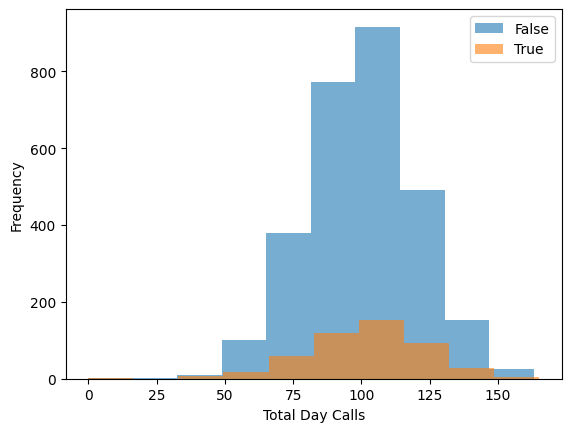

In [31]:
for category, group in churn_data.groupby('Churn'):
    plt.hist(group['Total day calls'], alpha=0.6, label=category)

# Add legend to distinguish categories
plt.legend()

# Add labels and title
plt.xlabel('Total Day Calls')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

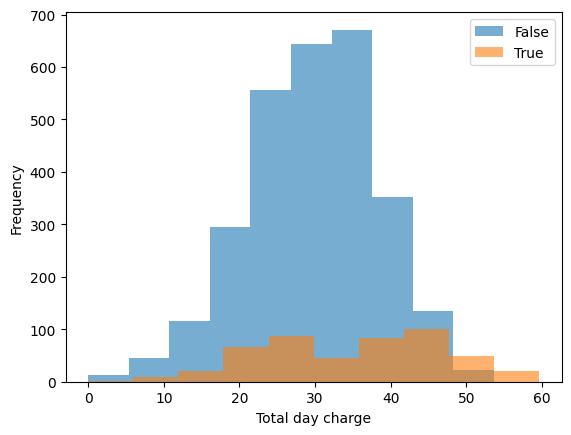

In [33]:
for category, group in churn_data.groupby('Churn'):
    plt.hist(group['Total day charge'], alpha = 0.6, label = category)

plt.legend()
plt.xlabel('Total day charge')
plt.ylabel('Frequency')

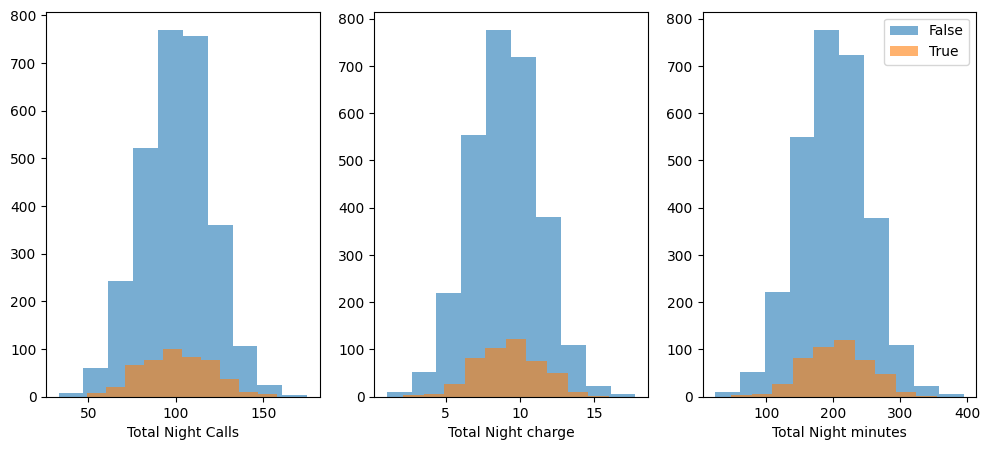

In [53]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(1,3,figsize=(12, 5))

# Plot each histogram
for category, group in churn_data.groupby('Churn'):
    axs[0].hist(group['Total night calls'],alpha = 0.6, label = category)
    axs[0].set_xlabel('Total Night Calls')

    axs[1].hist(group['Total night charge'],alpha = 0.6, label = category)
    axs[1].set_xlabel('Total Night charge')

    axs[2].hist(group['Total night minutes'],alpha = 0.6, label = category)
    axs[2].set_xlabel('Total Night minutes')


plt.legend()




In [ ]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(1,3,figsize=(12, 5))

# Plot each histogram
for category, group in churn_data.groupby('Churn'):
    axs[0].hist(group['Total eve calls'],alpha = 0.6, label = category)
    axs[0].set_xlabel('Total Eve Calls')

    axs[1].hist(group['Total eve charge'],alpha = 0.6, label = category)
    axs[1].set_xlabel('Total Eve charge')

    axs[2].hist(group['Total eve minutes'],alpha = 0.6, label = category)
    axs[2].set_xlabel('Total Eve minutes')


plt.legend()


# Splitting Data

## Preparing X and Y Variable

In [100]:
X = churn_data.drop(columns=['Churn'], axis = 1)
#X = churn_data[['State','International plan','Voice mail plan','Total intl calls','Customer service calls']]
X.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1


In [101]:
y = churn_data['Churn']
y.head()

0    False
1     True
2     True
3    False
4    False
Name: Churn, dtype: bool

After creating variable for X and Y, let's proceed on applying pre-processing on our Predictor Variable.

In [102]:
num_feature = X.select_dtypes(exclude='object').columns
cat_feature = X.select_dtypes(include='object').columns

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', cat_transformer, cat_feature),
        ('StandardScaler', num_transformer, num_feature)
    ]
)

X = preprocessor.fit_transform(X)



Now that we are done with pre-processing, let's move on to splitting the test and train data set.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=720)

X_train.shape, X_test.shape

((2333, 71), (1000, 71))

In [105]:
#Do Logistic Regression as our base model

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [106]:
#Try predicting using the model

predictions = model.predict(X_test)

In [107]:
#model.score(X_test,y_test) == 0.85

accuracy =accuracy_score(y_test,predictions)
accuracy

0.873

We acheived an accuracy of 85% for our logistic regression model. But is this an overfitted or underfitted model? One way to check is for us to perform a K-Fold Cross-validation our training data set. The ideal result is the average accuracy we will get from the k-fold cross validation result should be near on what we got from the test data set. In that way we can be sure that our model is not overfitting or underfitting.

In [108]:
cv = KFold(n_splits = 10, random_state = 720, shuffle=True)
cv_model = LogisticRegression()

scores = cross_val_score(cv_model,X_train, y_train, scoring = 'accuracy',cv = cv,n_jobs =-1 )
mean_score = np.mean(scores)
confidence_interval = np.std(scores) * 2

mean_score, confidence_interval


(0.8576941418143134, 0.04546664908255947)

Looks like we have a good performing model. It is not over or under fitting. The accuracy score we got from the test set is almost the same from the average accuracy score we got from the cross validation result. Awesome!

Now for our 2nd model, we will create Decision Tree. Decision tree models are also good for classification problem. Let's see if Decision Tree can perform better compare to our base model (Logistic Regression)

In [104]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

dtree_prediction = clf.predict(X_test)

dtree_accuracy = accuracy_score(y_test, dtree_prediction)
dtree_accuracy

0.907

Huge improvement from our base model accuracy! But before that, let's see if our cross validation model performance will have a close value to what get from using the test data set.

In [109]:

cv_model_2 = DecisionTreeClassifier()

scores_dtree = cross_val_score(cv_model_2,X_train, y_train, scoring = 'accuracy',cv = cv,n_jobs =-1 )
mean_score_dtree = np.mean(scores_dtree)
confidence_interval_dtree = np.std(scores) * 2

mean_score_dtree, confidence_interval_dtree

(0.9104123106269031, 0.04546664908255947)

Awesome! Looks like Decision tree was a better model even on the case of checking if it is an over or underfitting model! But we wont stop right there. Let's apply hyperparameter turning on our randomforest model and see if it can further improve our model!

In [128]:
#Random Forest Model with no Hyperparameter tuning

basic_rf = RandomForestClassifier()

basic_rf.fit(X_train,y_train)

print(f'Train Accuracy - :{basic_rf.score(X_train,y_train):.3f}')
print(f'Test Accuracy - :{basic_rf.score(X_test,y_test):.3f}')





Train Accuracy - :1.000
Test Accuracy - :0.924


In [129]:
scores_basic_rf = cross_val_score(basic_rf,X_train, y_train, scoring = 'accuracy',cv = cv,n_jobs =-1 )
mean_score_basic_rf = np.mean(scores_basic_rf)
confidence_interval_basic_rf= np.std(scores_basic_rf) * 2

mean_score_basic_rf, confidence_interval_basic_rf

(0.9408385605810498, 0.02305521098091568)

In [131]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]

#Criterion
criterion = ['entropy','gini']

#Number of features to consider at every split
max_features = ['log2','sqrt']

#Maximum number of levels in tree
max_depth = [2,4]

#Minimum number of samples require to split a node
min_samples_split = [2,5]

#Minimum number of samples required at each leaf node
min_samples_leaf = [1,2]

#Method of selecting samples for training each tree
bootstrap = [True, False]

In [133]:
# Create the random grid

param_grid = {
    'n_estimators' : n_estimators,
    'criterion':criterion,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap,
}
print(param_grid)


{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'criterion': ['entropy', 'gini'], 'max_features': ['log2', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [134]:
rf_Model = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose = 2,n_jobs = 4)

In [135]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'], 'max_depth': [2, 4],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [136]:
#Check the best model
rf_Grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 17}

In [137]:
#Check accuracy
print(f'Train Accuracy - :{rf_Grid.score(X_train,y_train):.3f}')
print(f'Test Accuracy - :{rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - :0.870
Test Accuracy - :0.859


In [130]:
scores_hype_rf = cross_val_score(rf_Grid,X_train, y_train, scoring = 'accuracy',cv = cv,n_jobs =-1 )
mean_score_hype_rf = np.mean(scores_hype_rf)
confidence_interval_hype_rf= np.std(scores_hype_rf) * 2

mean_score_hype_rf, confidence_interval_hype_rf

(0.8782638201093137, 0.04264795537437277)

For our last model, we will use XGBoost Classifier.

In [112]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

xgb_prediction = xgb_model.predict(X_test)
xgb_accuracy_score = accuracy_score(y_test,xgb_prediction)
xgb_accuracy_score

0.952

95%! Amazing! Again let's validate this result by conducting cross-validation method

In [113]:
scores_xgb = cross_val_score(xgb_model,X_train, y_train, scoring = 'accuracy',cv = cv,n_jobs =-1 )
mean_score_xgb = np.mean(scores_xgb)
confidence_interval_xgb = np.std(scores_xgb) * 2

mean_score_xgb, confidence_interval_xgb

(0.9481365320421113, 0.020437459791835692)

Perfect! We can safely say that the performance of our model is accurate and not overfitting.